<a href="https://colab.research.google.com/github/msc-acse/acse-9-independent-research-project-OliverJBoom/blob/master/Chai_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linking to Github

In [0]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!rm -rf Chai_Base
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git Chai_Base

github password··········
Cloning into 'Chai_Base'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17 (delta 3), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (17/17), done.


## Linking to Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")
path = "/content/gdrive/My Drive/Chai/Data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


## Loading Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

## Loading Data

In [0]:
cu_lme =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuLME.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
cu_shfe =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuSHFE.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
cu_com_s =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuCOMS.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
cu_com_p =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuCOMP.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)

universe_dict = {"lme":cu_lme, "shfe":cu_shfe, "com s":cu_com_s, "com p":cu_com_p}

In [0]:
def visualise_plots(universe_dict, frequency="MS"):
  """Plotting the line graph for all of the 
  instruments being inspected"""
  for df_name in universe_dict:
    df = universe_dict[df_name]
    plt.plot(df.index, df.price)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(df_name)
    plt.grid()
    plt.show()
    
# visualise_plots(universe_dict)
# df.info()
# plt.hist((df.price), bins=20)
# plt.show()

## Preprocessing

In [0]:
df = universe_dict["lme"]  

In [64]:
def price_rename(universe_dict):
  """Renaming the column of the dataframe values to price"""
  for df_name in universe_dict:
    df = universe_dict[df_name]
    df = df.rename(columns={'value':"price"})
    universe_dict[df_name] = df
  return universe_dict


def clean_data(df, n_std = 20):
  """Removes any outliers that are further than a chosen
  number of standard deviations from the mean"""
  upper = df.price.mean() + n_std * (df.price.std())
  lower = df.price.mean() - n_std * (df.price.std())
  df.loc[((df.price > upper) | (df.price < lower)), 'price'] = None
  # TODO Upsample
  if df.price.isnull().sum() > 0: print("Rows removed:", df.price.isnull().sum())
  return df


def clean_dict_gen(universe_dict):
  """Returns a dictionary of cleaned dataframes"""
  cleaned_dict = {}
  
  for df in universe_dict:
    print(df)
    cleaned_dict[df] = clean_data(universe_dict[df])
    
  return cleaned_dict


universe_dict = clean_dict_gen(price_rename(universe_dict))

lme
shfe
com s
com p


In [0]:
def feature_spawn(df):
  """Spawsn features for each instrument
  Returns df with the following columns
  Price
  Log Returns
  EWMA 1 day
  EWMA 1 week
  EWMA 1 month
  EWMA 1 quarter
  EWMA 6 months
  EWMA 1 year
  Rolling vol 1 week
  Rolling vol 1 month
  Rolling vol 1 quarter
  """
  df["lg_return"] = np.log(df.price) - np.log(df.price.shift(1))
  #df["deciles_lg_return"] = pd.qcut(df.lg_return, 10, labels=False)
  df.lg_return.fillna(0, inplace=True)
  
  hlf_dict = {"week":5, "month":22, "quarter":66, "half_year":130, "year":261}

  for half_life in hlf_dict:
    df["ema_" + half_life] = df.price.ewm(span=hlf_dict[half_life]).mean()
    
  for i, half_life in enumerate(hlf_dict):
    if i < 3:
      df["roll_vol_" + half_life] = df.price.rolling(window=hlf_dict[half_life]).std(ddof=0)
  
  df.dropna(inplace=True)
  return df

In [0]:
df = feature_spawn(df)

In [92]:
print(df.columns)

Index(['price', 'lg_return', 'ema_week', 'ema_month', 'ema_quarter',
       'ema_half_year', 'ema_year', 'roll_vol_week', 'roll_vol_month',
       'roll_vol_quarter'],
      dtype='object')


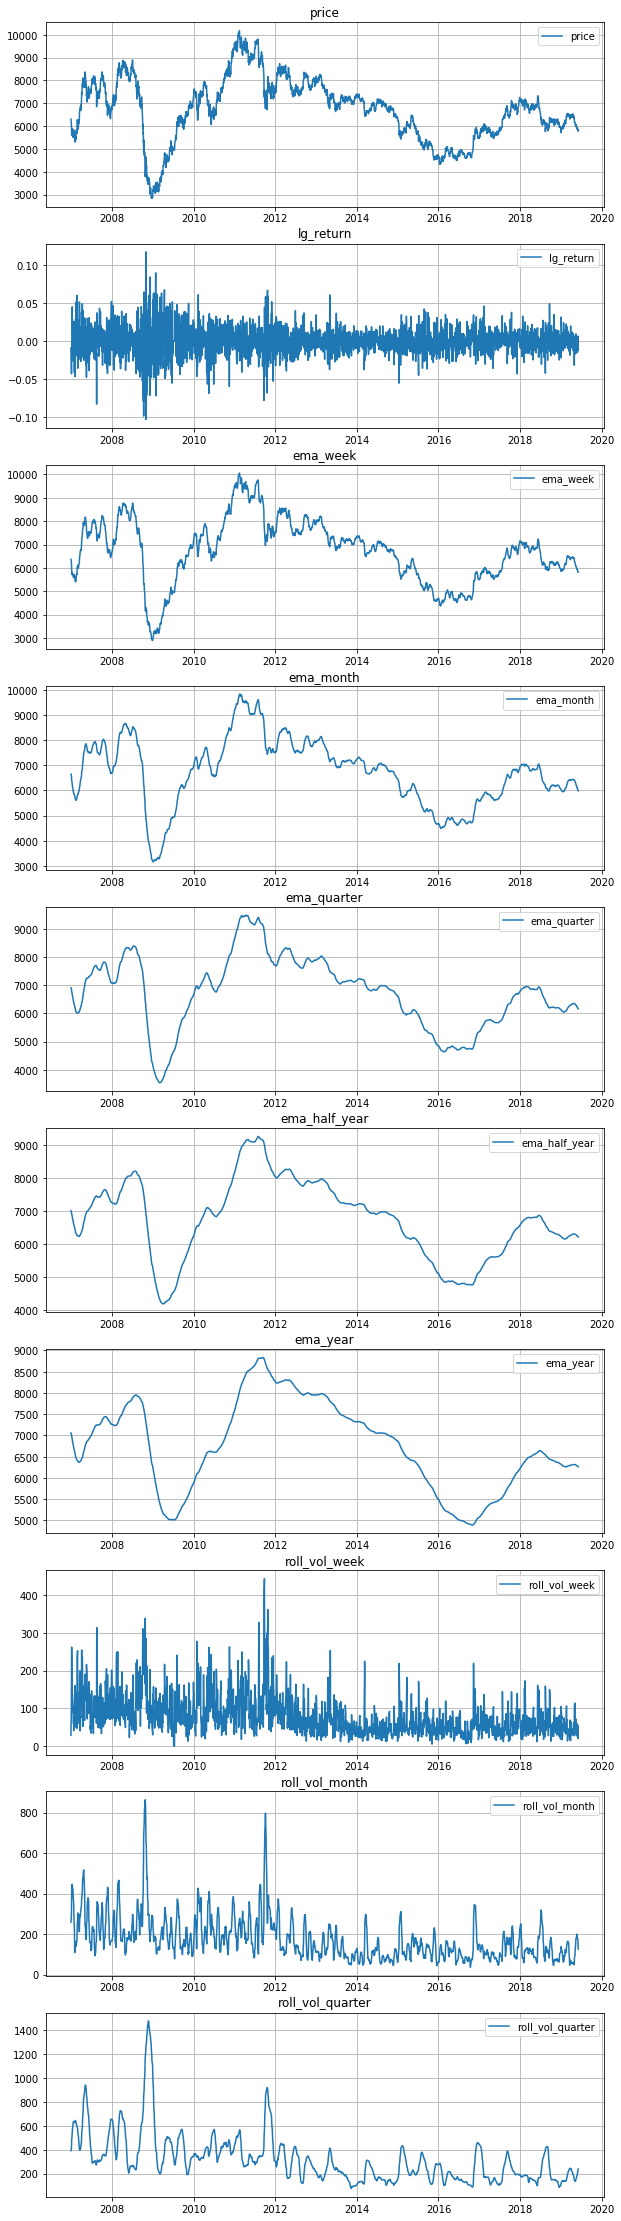

In [93]:
fig, axarr = plt.subplots(len(df.columns), 1, figsize=(10, 4 * len(df.columns)))

for i, (ax, df_name) in enumerate(zip(axarr.flatten(), df.columns)):
    
    ax.set_title(df_name)
    ax.plot(df.index, df[df_name])
    ax.grid()
    ax.legend()
    
plt.show()